In [1]:
import numpy as np
import pandas as pd
import comonotonic as cm
import utils
from utils import df_split_discretize
from utils import check_accuracy
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [2]:
df = pd.read_csv("Datasets/adult.csv")
random_state = 42
colnames = [('X'+str(i)) for i in range(df.shape[1]-1)]
colnames.append('Y')
df.columns = colnames

In [3]:
#data cleaning for adult.csv
df = df[df.X1 != '?']
df = df[df.X6 != '?']
# unrankable features
encoded_df = utils.encode_df(df, [1,5,6,7,8,9,13])

encoded_df.loc[(encoded_df.Y == "<=50K"),'Y'] = 0
encoded_df.loc[(encoded_df.Y == ">50K"),'Y'] = 1

encoded_df.loc[(encoded_df.X4 <= 9),'X3'] = 0
encoded_df.loc[(encoded_df.X4 == 10),'X3'] = 1
encoded_df.loc[(encoded_df.X4 == 11),'X3'] = 2
encoded_df.loc[(encoded_df.X4 == 12),'X3'] = 2
encoded_df.loc[(encoded_df.X4 >= 13),'X3'] = 3

encoded_df = encoded_df.astype('int32')

In [4]:
cont_col = [0,2,4,10,11,12]
unrankable = [1,5,6,7,8,9,13]
discrete_col = [1,3,5,6,7,8,9,13]
discrete_feature_val = {k:encoded_df['X'+str(k)].nunique() for k in discrete_col}
possible_categories = [i for i in range(2,11)]
allocation_book = {i: np.random.choice(possible_categories) for i in cont_col}

In [5]:
max_itr = 250
temp = 100
anneal_schedule = 10
qcut = False
overall_acc_hist = []
classwise_acc_hist = []

In [6]:
for itr in range(max_itr):
    if (itr+1) % anneal_schedule == 0:
        temp /= 10
    if itr == 0:
        x_train,x_test,y_train,y_test = df_split_discretize(encoded_df,random_state,qcut,allocation_book)
        classwise_acc, overall_acc = check_accuracy(x_train,x_test,y_train,y_test,discrete_feature_val,cont_col,unrankable)
        overall_acc_hist.append(overall_acc)
        classwise_acc_hist.append(classwise_acc)
    else:
        chosen_idx = np.random.choice(cont_col)
        chosen_category = np.random.choice(possible_categories)
        proposal = allocation_book.copy()
        proposal[chosen_idx] = chosen_category
        x_train,x_test,y_train,y_test = df_split_discretize(encoded_df,random_state,qcut,proposal)
        propose_class_acc, propose_overall_acc = check_accuracy(x_train,x_test,y_train,y_test,discrete_feature_val,cont_col,unrankable)
        prev_acc = overall_acc_hist[-1]
        if propose_overall_acc > prev_acc:
            allocation_book = proposal.copy()
            overall_acc_hist.append(propose_overall_acc)
            classwise_acc_hist.append(propose_class_acc)            
        else:
            transition_prob = math.exp((propose_overall_acc - prev_acc)/temp)
            determinant = np.random.uniform(0,1)
            if determinant <= transition_prob:
                allocation_book = proposal.copy()
                overall_acc_hist.append(propose_overall_acc)
                classwise_acc_hist.append(propose_class_acc)
            else:
                overall_acc_hist.append(overall_acc_hist[-1])
                classwise_acc_hist.append(classwise_acc_hist[-1])

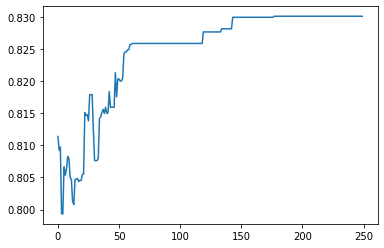

In [7]:
plt.plot(overall_acc_hist)

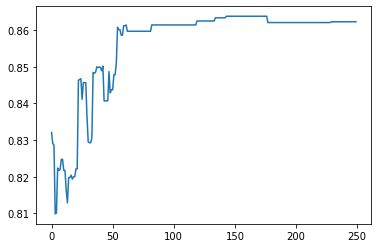

In [8]:
class0_hist = [class_acc[0] for class_acc in classwise_acc_hist]
plt.plot(class0_hist)

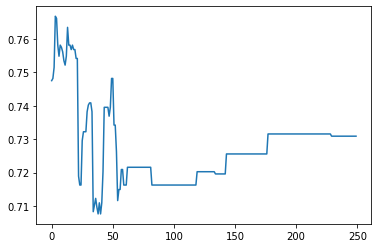

In [9]:
class1_hist = [class_acc[1] for class_acc in classwise_acc_hist]
plt.plot(class1_hist)